In [1]:
from pathlib import Path
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score 
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

In [2]:
path = Path(os.getcwd()).parent

gbs = pd.read_csv(os.path.join(path, 'data/gbs_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gesis = pd.read_csv(os.path.join(path, 'data/gesis_processed.csv'), encoding = "ISO-8859-1", delimiter = ',')
gbs = gbs.fillna(gbs.median())
gesis = gesis.fillna(gesis.median())

gbs['Umfrage'] = 1
gesis['Umfrage'] = 0

gesis.drop(columns = ['GESIS-CODE'], axis=1, inplace = True)
gbs.drop(columns = ['GBS-CODE', 'Gruppe'], axis=1, inplace = True)
drop = ['Personen im Haushalt', 'Druck', 'Optimismus Zukunft', 'Geburtsland', 'Nationalitaet',
       'Familienstand', 'Berufsgruppe', 'Leben genießen', 'Zu Nichts aufraffen',
       'Alles anstrengend', 'Zufriedenheit Leben', 'Aktiv', 'Verärgert', 'Nervös', 'Ängstlich', 'Zurueckhaltend',
       'Nettoeinkommen Selbst', 'Nettoeinkommen Haushalt', 'Schlechter Schlaf',
       'Wahlabsicht', 'Desinteresse Politiker']

gbs.drop(columns=drop, axis=1, inplace=True)
gesis.drop(columns=drop, axis=1, inplace=True)

df = pd.concat([gesis, gbs])
df.to_csv(os.path.join(path, 'data/gbs_and_gesis.csv'), encoding = "ISO-8859-1", index= False)
df1 = pd.concat([gesis.head(2124), gbs.head(289)])
df2 = pd.concat([gesis.tail(2125), gbs.tail(290)])

best params: LogisticRegression(C=1.50001, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=450,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)
best params: {'C': 1.50001}
best score: 0.6842105263157895


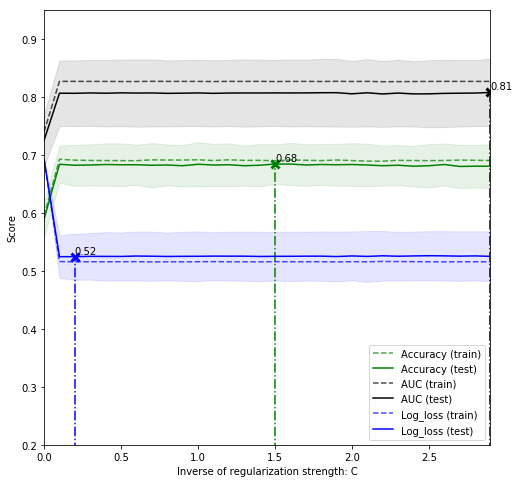

In [3]:
#grid search code from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

y = df1.Umfrage
X = df1.drop(columns=['Umfrage'], axis=1).copy()

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=450), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')
gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(8, 8))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Inverse of regularization strength: C")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.2, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.savefig(os.path.join(path, 'tex/fig/logistic_grid.png'))
plt.show()

c:\users\laksa\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


best params: SVC(C=8.00001, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best params: {'C': 8.00001}
best score: 0.6324077911313717


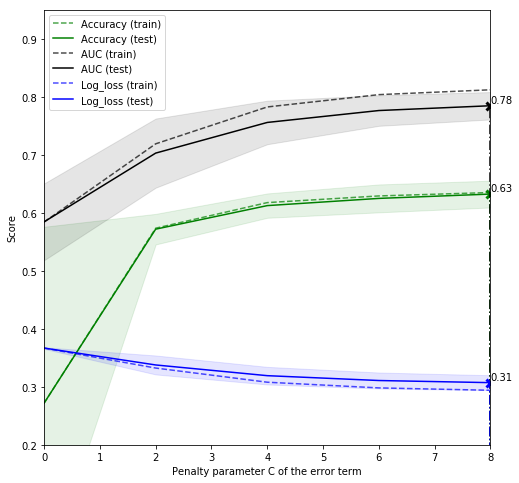

In [4]:
#grid search code from: https://www.kaggle.com/mnassrib/titanic-logistic-regression-with-python

from sklearn import svm

y = df1.Umfrage
X = df1.drop(columns=['Umfrage'], axis=1).copy()

#param_grid = {'C': np.arange(1e-05, 10, 0.1)}
param_grid = {'C': np.arange(1e-05, 10, 2)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(svm.SVC(gamma='scale', class_weight='balanced', probability=True), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=5, refit='Accuracy')
gs.fit(X, y)
results = gs.cv_results_

print('='*20)
print("best params: " + str(gs.best_estimator_))
print("best params: " + str(gs.best_params_))
print('best score:', gs.best_score_)
print('='*20)

plt.figure(figsize=(8, 8))
#plt.title("GridSearchCV evaluating using multiple scorers simultaneously",fontsize=16)

plt.xlabel("Penalty parameter C of the error term")
plt.ylabel("Score")
plt.grid()

ax = plt.axes()
ax.set_xlim(0, param_grid['C'].max()) 
ax.set_ylim(0.2, 0.95)

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results['param_C'].data, dtype=float)

for scorer, color in zip(list(scoring.keys()), ['g', 'k', 'b']): 
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = -results['mean_%s_%s' % (sample, scorer)] if scoring[scorer]=='neg_log_loss' else results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = -results['mean_test_%s' % scorer][best_index] if scoring[scorer]=='neg_log_loss' else results['mean_test_%s' % scorer][best_index]
        
    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.savefig(os.path.join(path, 'tex/fig/svm_grid.png'))
plt.show()

In [5]:
'''svm1 = svm.SVC(C= 9, gamma='scale', class_weight='balanced', probability=True)
svm2 = svm.SVC(C = 1e-05, gamma='scale', class_weight='balanced', probability=True)
'''
lg1 = LogisticRegression(C = 1.5, solver='lbfgs', class_weight='balanced', max_iter=650)
lg2 = LogisticRegression(C = 0.5, solver='lbfgs', class_weight='balanced', max_iter=650)

In [6]:
y1 = df1.Umfrage
X1 = df1.drop(columns=['Umfrage'], axis=1).copy()

y2 = df2.Umfrage
X2 = df2.drop(columns=['Umfrage'], axis=1).copy()

lg1.fit(X1, y1)
lg2.fit(X2, y2)

lg2_pred = lg1.predict_proba(X2) #predicts second half
lg1_pred = lg2.predict_proba(X1) #predicts first half
lg_pred = [i[1] for i in lg1_pred] + [i[1] for i in lg2_pred]

'''svm1.fit(X1, y1)
svm2.fit(X2, y2)

svm2_pred = svm1.predict_proba(X2) #predicts second half
svm1_pred = svm2.predict_proba(X1) #predicts first half
svm_pred = [i[1] for i in svm1_pred] + [i[1] for i in svm2_pred]'''

'svm1.fit(X1, y1)\nsvm2.fit(X2, y2)\n\nsvm2_pred = svm1.predict_proba(X2) #predicts second half\nsvm1_pred = svm2.predict_proba(X1) #predicts first half\nsvm_pred = [i[1] for i in svm1_pred] + [i[1] for i in svm2_pred]'

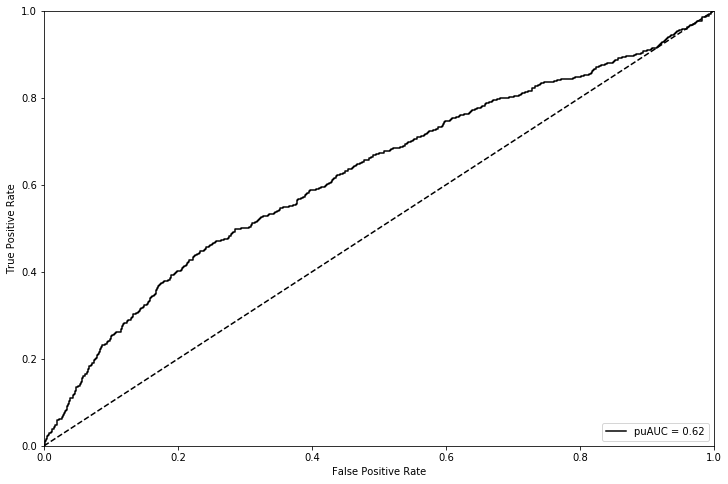

In [11]:
def roc(y_test, preds):
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(12,8))
    label = 'puAUC = %0.2f' % roc_auc
    plt.plot(fpr, tpr, 'black', label = label)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.savefig(os.path.join(path, 'tex/fig/disc_learning_roc.png'))
    plt.show()
    
roc(df.Umfrage, lg_pred)